### Interpretations of the Data Part 1

In this script, we attempted to make sense of the data 

1) We tried labelling the genres and then plotted Gross vs IMdB Scores against all movies

2) We tried labelling the ratings, plotted Gross vs IMdB Scores against all movies, and then attempted to plot a KDE to estimate the probability density function (assumed Normal)

3) We attemped to plot Gross vs 1st Actor Facebook Likes and Gross vs. Positive Critic Reviews. Applied KNN to see if we could classify the data accordingly

None of the above gave us an intuition or insight on any type of correlation in the data...

In [1]:
# Packages
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA

In [2]:
# Read in the data
data = pd.read_csv("movie_metadata.csv")

# Drop all missing data 
data = data.dropna()

# Set the labels as content ratings
movie_content_ratings = ['G', 'PG', 'PG-13', 'R']

# Look for the data (under the content ratings column) that is in the movie_content_ratings list above
data = data.loc[data['content_rating'].isin(movie_content_ratings)]

# Genre as Labels

In [3]:
# Set the Gross and Movie Scores 
gross = data['gross'].values
movie_score = data['imdb_score'].values

In [4]:
# Label the Genres from 0 - 20
np.random.seed(0)
genres = data['genres'].values # Get the column of Genres
select_genres=[]
for i in range(genres.size):
    the_genres = re.split("[|]", genres[i]) # Split up the Genres (tokenizing them in way)
    genre_index = np.random.randint(0, len(the_genres)) # create a random number from 0 - 20
    select_genres.append(the_genres[genre_index]) # put the genre number back into the list
unique_labels = np.unique(select_genres) # get the unique labels
labels = np.zeros(len(select_genres))
for i in range(genres.size):
    # Count to check how many movies in total per each specific genre 
    labels[i] = sum(((unique_labels[j] == select_genres[i]) * j for j in range(unique_labels.shape[0])))

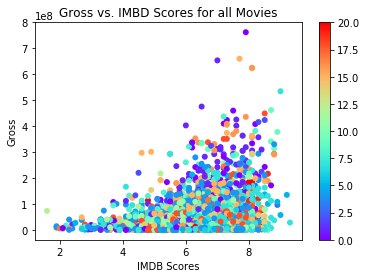

In [5]:
fig = plt.figure()
plt.scatter(movie_score, gross, edgecolor='none', c=labels, cmap='rainbow')
plt.colorbar()
plt.xlabel('IMDB Scores')
plt.ylabel('Gross')
plt.title('Gross vs. IMBD Scores for all Movies')
plt.show()

# Rating as Labels

In [6]:
# Set the Gross and Movie Scores 
gross = data['gross'].values
movie_score = data['imdb_score'].values

In [7]:
# Label the Genres from 0 - 3
np.random.seed(0)
content_rate = data['content_rating'].values # get the content column
unique_labels = movie_content_ratings # create the unique ratings
labels = np.zeros(len(select_genres))
for i in range(genres.size):
# Count to check how many movies are G, PG, PG-13, R
    labels[i] = sum(((unique_labels[j] == content_rate[i]) * j for j in range(len(unique_labels))))

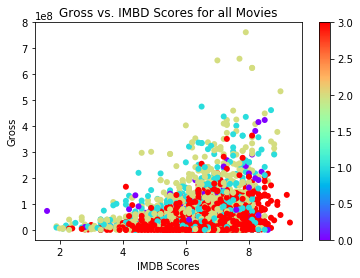

In [8]:
fig = plt.figure()
plt.scatter(movie_score, gross, edgecolor='none', c=labels, cmap='rainbow')
plt.colorbar()
plt.xlabel('IMDB Scores')
plt.ylabel('Gross')
plt.title('Gross vs. IMBD Scores for all Movies')
plt.show()

In [9]:
# Instantiate KDE using the movie scores
kde = KernelDensity(kernel='gaussian').fit(movie_score.reshape(-1,1))

In [10]:
samples = np.linspace(0, 10, movie_score.shape[0])[:, np.newaxis]
log_density = kde.score_samples(samples)

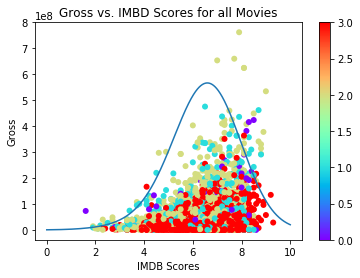

In [11]:
fig = plt.figure()
plt.scatter(movie_score, gross, edgecolor='none', c=labels, cmap='rainbow')
plt.plot(samples, np.exp(log_density)*2000000000)
plt.colorbar()
plt.xlabel('IMDB Scores')
plt.ylabel('Gross')
plt.title('Gross vs. IMBD Scores for all Movies')
plt.show()

# Gross vs. 1st Actor Facebook Likes

In [12]:
# Set the Gross and 1st Actor Facebook Likes
gross = data['gross'].values
actor_facebook_like = data['actor_1_facebook_likes'].values

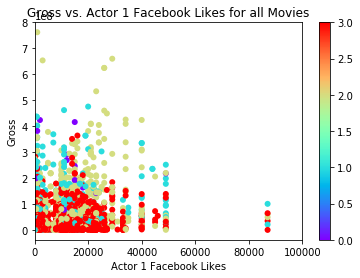

In [13]:
fig = plt.figure()
plt.scatter(actor_facebook_like, gross, edgecolor='none', c=labels, cmap='rainbow')
plt.colorbar()
plt.xlabel('Actor 1 Facebook Likes')
plt.ylabel('Gross')
plt.xlim(left=0, right=100000)
plt.title('Gross vs. Actor 1 Facebook Likes for all Movies')
plt.show()

# Gross vs. Positive Critic Reviews

In [22]:
# Set the Gross and Number of Critics for Review 
gross = data['gross'].values
pos_critic = data['num_critic_for_reviews'].values

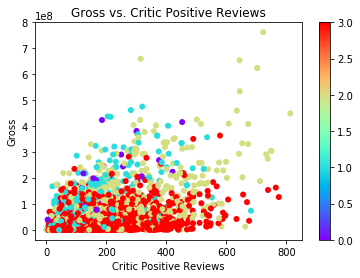

In [16]:
fig = plt.figure()
plt.scatter(pos_critic, gross, edgecolor='none', c=labels, cmap='rainbow')
plt.colorbar()
plt.xlabel('Critic Positive Reviews')
plt.ylabel('Gross')
plt.title('Gross vs. Critic Positive Reviews')
plt.show()

In [17]:
X = np.zeros((gross.shape[0], 2))
X[:, 0] = pos_critic
X[:, 1] = gross

In [18]:
# Using PCA with 2 components, let's try and clean up the data
pca = PCA(n_components=2, whiten=True)
Z1 = pca.fit_transform(X)

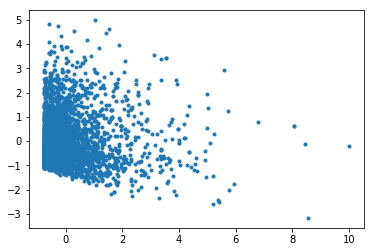

In [19]:
plt.plot(Z1[:,0], Z1[:,1],'.')
plt.show()

# _k_ Nearest Neighbors

In [20]:
X = np.zeros((gross.shape[0], 2))
X[:, 0] = movie_score
X[:, 1] = gross
y = labels

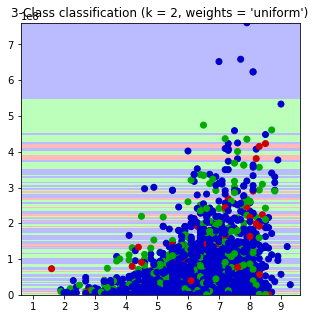

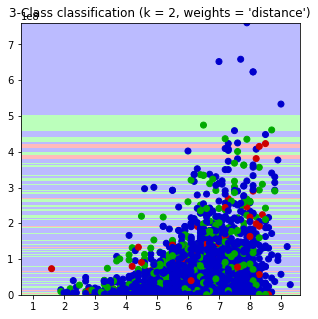

In [21]:
from sklearn import neighbors

# create color maps
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

n_neighbors = 2

h = 1  # step size in the mesh

x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h*1000000))
grid = np.c_[xx.ravel(), yy.ravel()]

for weights in ['uniform', 'distance']:
    
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)
    
    ZZ = clf.predict(grid)
    ZZ = ZZ.reshape(xx.shape) # 2-D grid layout

    # Plot the decision boundary. For that, we will assign a color to each grid point
    plt.figure(figsize=(5,5))
    plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))